# Random Forest

---

Aditya Marathe

## Imports and version

In [1]:
# %matplotlib inline

import sys

import numpy as np
import numpy.typing as npt

import tensorflow as tf
from tensorflow import keras

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


**Local**:

In [2]:
sys.path.insert(1, './../')

import ana
from utils import *
from transforms import *

In [3]:
ana.init_global_plotting_style()

**Version**:

In [4]:
print(f'Python {sys.version}\n')
print(f'NumPy {np.__version__}')
print(f'Matplotlib {mpl.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

NumPy 1.26.1
Matplotlib 3.8.1


## Load dataset

In [5]:
ds = Datasets()

Datasets found:
- MINI_DATA_DIR
- DATA_V2_DIR
- DATA_V3_DIR
- REALLY_MINI_DIR
- COPYMERGED_C6_DIR
- COPYMERGED_C7_DIR
- COPYMERGED_C8_DIR
- COPYMERGED_C9_DIR
- COPYMERGED_C10_DIR


In [6]:
data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        # ds.COPYMERGED_C8_DIR,  # type: ignore
        # ds.COPYMERGED_C9_DIR,  # type: ignore
        ds.COPYMERGED_C10_DIR  # type: ignore
    ]
)

In [7]:
data.table.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 184661 entries, (15021, 10, 0, 0, 1, 1) to (15112, 63, 0, 0, 1000, 2)
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   rec.energy.numu.E                   184661 non-null  float32
 1   rec.energy.numu.calccE              184661 non-null  float32
 2   rec.energy.numu.hadcalE             184661 non-null  float32
 3   rec.energy.numu.hadtrkE             184661 non-null  float32
 4   rec.energy.numu.lstmmuon            184661 non-null  float32
 5   rec.energy.numu.lstmnu              184661 non-null  float32
 6   rec.energy.numu.regcvnhadE          184661 non-null  float32
 7   rec.energy.numu.trkccE              184661 non-null  float32
 8   rec.energy.numu.recomuonE           184661 non-null  float32
 9   rec.energy.numu.hadclust.calE       184661 non-null  float32
 10  rec.energy.numu.hadclust.nhit       184661 non-nul

In [8]:
data.fill_ana_flags(inplace=True)
data.fill_ana_track_kinematics(inplace=True)

## Data prep.

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
cuts = ana.Cuts.init_nova_cuts()

In [11]:
table = data.table.reset_index(drop=True)

In [12]:
# Cuts
table = cuts.apply_cut('Detector Quality', table)
table = cuts.apply_cut('Data Quality', table)
table = cuts.apply_cut('Cosmic Rej.', table)
table = cuts.apply_cut('Veto', table)
# table = cuts.apply_cut('CVN PID Score', table)
# table = cuts.apply_cut('Containment', table)

In [13]:
# Full cuts for comparison
full_cuts_table = cuts.apply_all_cuts(table)

In [14]:
def tf_120224_first_prong(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    
    targets = [
        'ana.trk.kalman.tracks.cosBeam', 
	    'ana.trk.kalman.tracks.PtToPmu',
        'ana.trk.kalman.tracks.Pt',
        'ana.trk.kalman.tracks.Qsquared',
        'ana.trk.kalman.tracks.W'
    ]

    for target in targets:
        df_copy[target] = df_copy[target].apply(
            lambda row: row[0] if len(row) > 0 else float('nan')
        )

    return df_copy

In [15]:
def tf_200224_add_cut_vars(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()

    df_copy = cuts.apply_cut('CVN PID Score', df_copy)
    passed_cvn_pid_index = df_copy.index

    df_copy = df.copy()

    df_copy = cuts.apply_cut('Containment', df_copy)
    passed_containment_index = df_copy.index
    
    #

    df_copy = df.copy()

    df_copy.loc[passed_cvn_pid_index, 'ana.cut.flag.cvn_pid'] = 1.
    df_copy.loc[passed_containment_index, 'ana.cut.flag.containment'] = 1.

    df_copy[['ana.cut.flag.cvn_pid', 'ana.cut.flag.containment']] = df_copy[['ana.cut.flag.cvn_pid', 'ana.cut.flag.containment']].fillna(value=0)

    return df_copy


In [16]:
# Transforms
table = tf_290124_positive_energies(table)
table = tf_290124_valid_pid(table)
# table = tf_120224_numu_energy(table)
table = tf_120224_first_prong(table)
table = tf_200224_add_cut_vars(table)

In [17]:
# Transforms
full_cuts_table = tf_290124_positive_energies(full_cuts_table)
full_cuts_table = tf_290124_valid_pid(full_cuts_table)

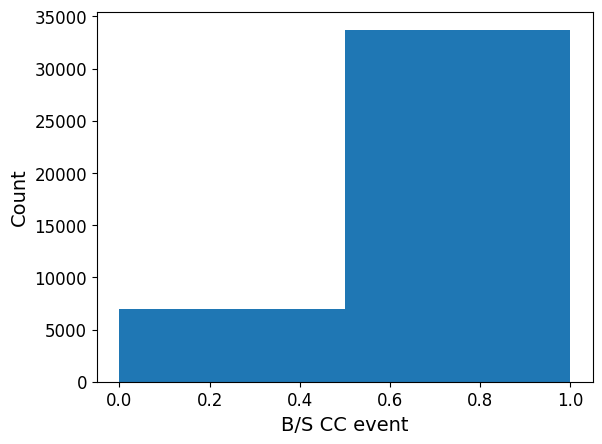

In [18]:
plt.hist(
    table['rec.mc.nu.iscc'],
    bins=np.linspace(0, 1, 2 + 1)  # type: ignore
)
plt.ylabel('Count')
plt.xlabel('B/S CC event');

In [19]:
useful_vars = [
	'rec.energy.numu.calccE',
	'rec.energy.numu.hadcalE',
	'rec.energy.numu.hadtrkE',
	'rec.energy.numu.lstmmuon',
	'rec.energy.numu.lstmnu',
	'rec.energy.numu.regcvnhadE',
	'rec.energy.numu.trkccE',
	'rec.energy.numu.recomuonE',
	'rec.energy.numu.hadclust.calE',
	'rec.energy.numu.hadclust.nhit',
	'rec.sel.contain.kalfwdcell',
	'rec.sel.contain.kalbakcell',
	'rec.sel.contain.cosfwdcell',
	'rec.sel.contain.cosbakcell',
	'rec.sel.cosrej.numucontpid2020fhc',
	'rec.sel.cvnloosepreselptp.cosmicid',
	'rec.sel.cvnloosepreselptp.ncid',
	'rec.sel.cvnloosepreselptp.nueid',
	'rec.sel.cvnloosepreselptp.numuid',
	'rec.sel.remid.pid',
	'rec.sel.scann.scpid',
	'rec.slc.calE',
	'rec.slc.firstplane',
	'rec.slc.lastplane',
	'rec.slc.nhit',
	'rec.slc.ncontplanes',
	'rec.trk.kalman.ntracks',
	'rec.trk.kalman.ntracks2d',
	'ana.trk.kalman.tracks.cosBeam', 
	'ana.trk.kalman.tracks.PtToPmu',
	'ana.trk.kalman.tracks.Pmu', 
	'ana.trk.kalman.tracks.Pt',
    'ana.cut.flag.cvn_pid',
    'ana.cut.flag.containment',
	'ana.mc.flag.isNuMuCC'
]

scale_vars = [
	'rec.energy.numu.calccE',
	'rec.energy.numu.hadcalE',
	'rec.energy.numu.hadtrkE',
	'rec.energy.numu.lstmmuon',
	'rec.energy.numu.regcvnhadE',
	'rec.energy.numu.trkccE',
	'rec.energy.numu.recomuonE',
	'rec.energy.numu.hadclust.calE',
	'rec.energy.numu.hadclust.nhit',
	'rec.sel.contain.kalfwdcell',
	'rec.sel.contain.kalbakcell',
	'rec.sel.contain.cosfwdcell',
	'rec.sel.contain.cosbakcell',
	'rec.slc.calE',
	'rec.slc.firstplane',
	'rec.slc.lastplane',
	'rec.slc.nhit',
	'rec.slc.ncontplanes',
	'rec.trk.cosmic.ntracks',
	'rec.trk.kalman.ntracks',
	'rec.trk.kalman.ntracks2d',
	'ana.trk.kalman.tracks.cosBeam', 
	'ana.trk.kalman.tracks.PtToPmu',
	'ana.trk.kalman.tracks.Pmu', 
	'ana.trk.kalman.tracks.Pt'
]

In [20]:
len(useful_vars)

35

IndexError: list index out of range

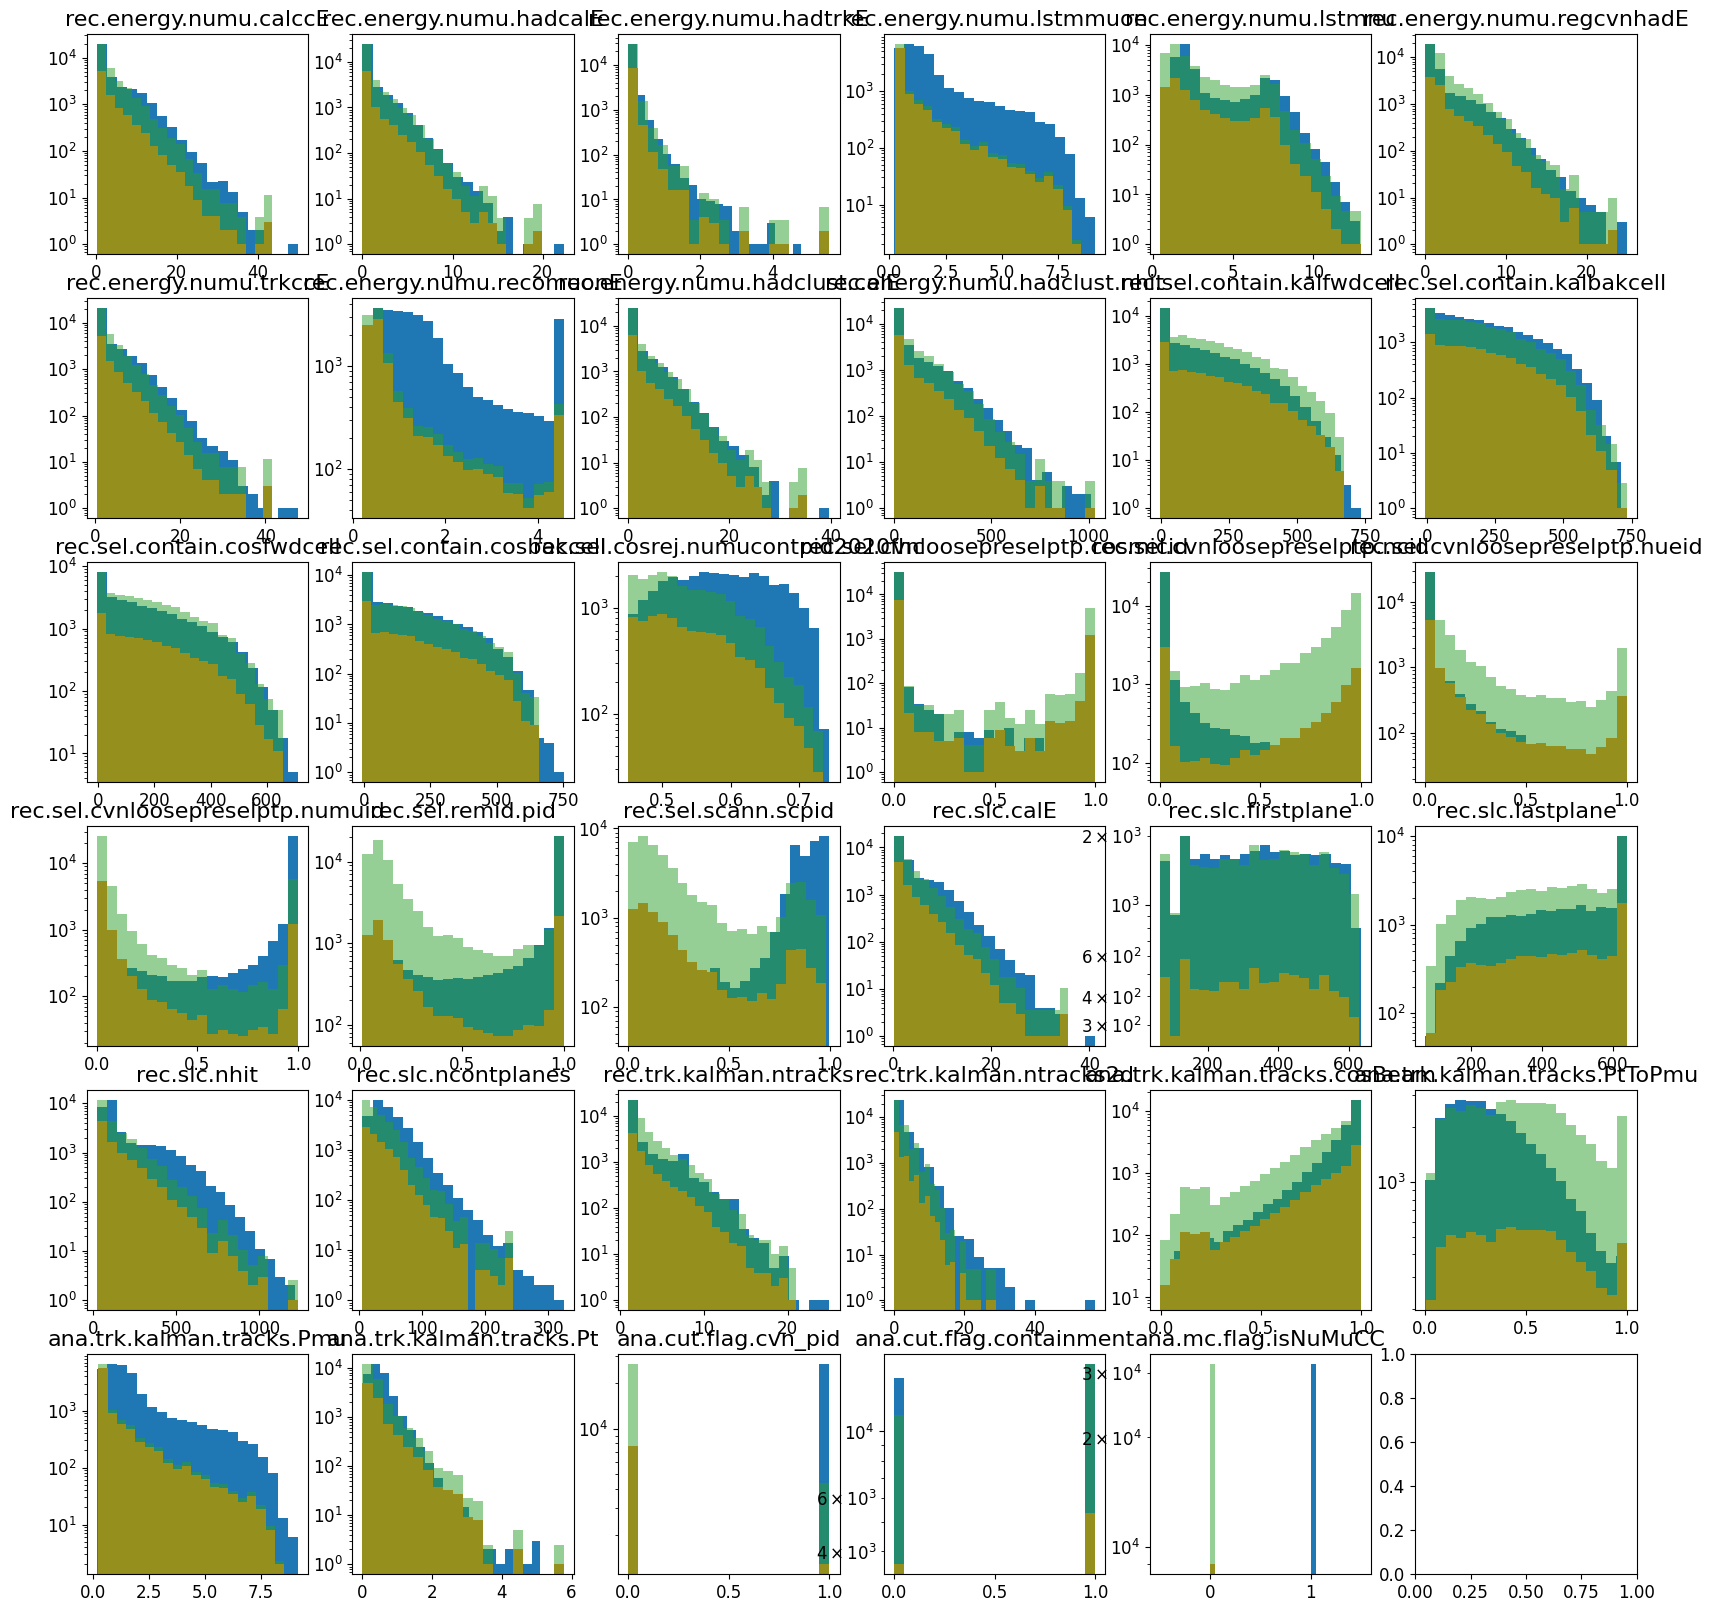

In [21]:
fig, axs = plt.subplots(6, 6, figsize=(20, 20))

axs = axs.flatten()

for i, ax in enumerate(axs):
    var = useful_vars[i]

    s_vals, edg, *_ = ax.hist(
        table[table['ana.mc.flag.isNuMuCC'] == 1][var],
        bins=20,
        label='signal'
    )
    b_vals, edg, *_ = ax.hist(
        table[table['ana.mc.flag.isNuMuCC'] == 0][var],
        bins=20,
        label='background'
    )
    ax.hist(
        edg[:-1],
        bins=edg,
        weights=b_vals * (s_vals.max() / b_vals.max()),
        alpha=0.5,
        label='scaled background'
    )
    ax.set_yscale('log')
    ax.set_title(var)

plt.tight_layout();

IndexError: list index out of range

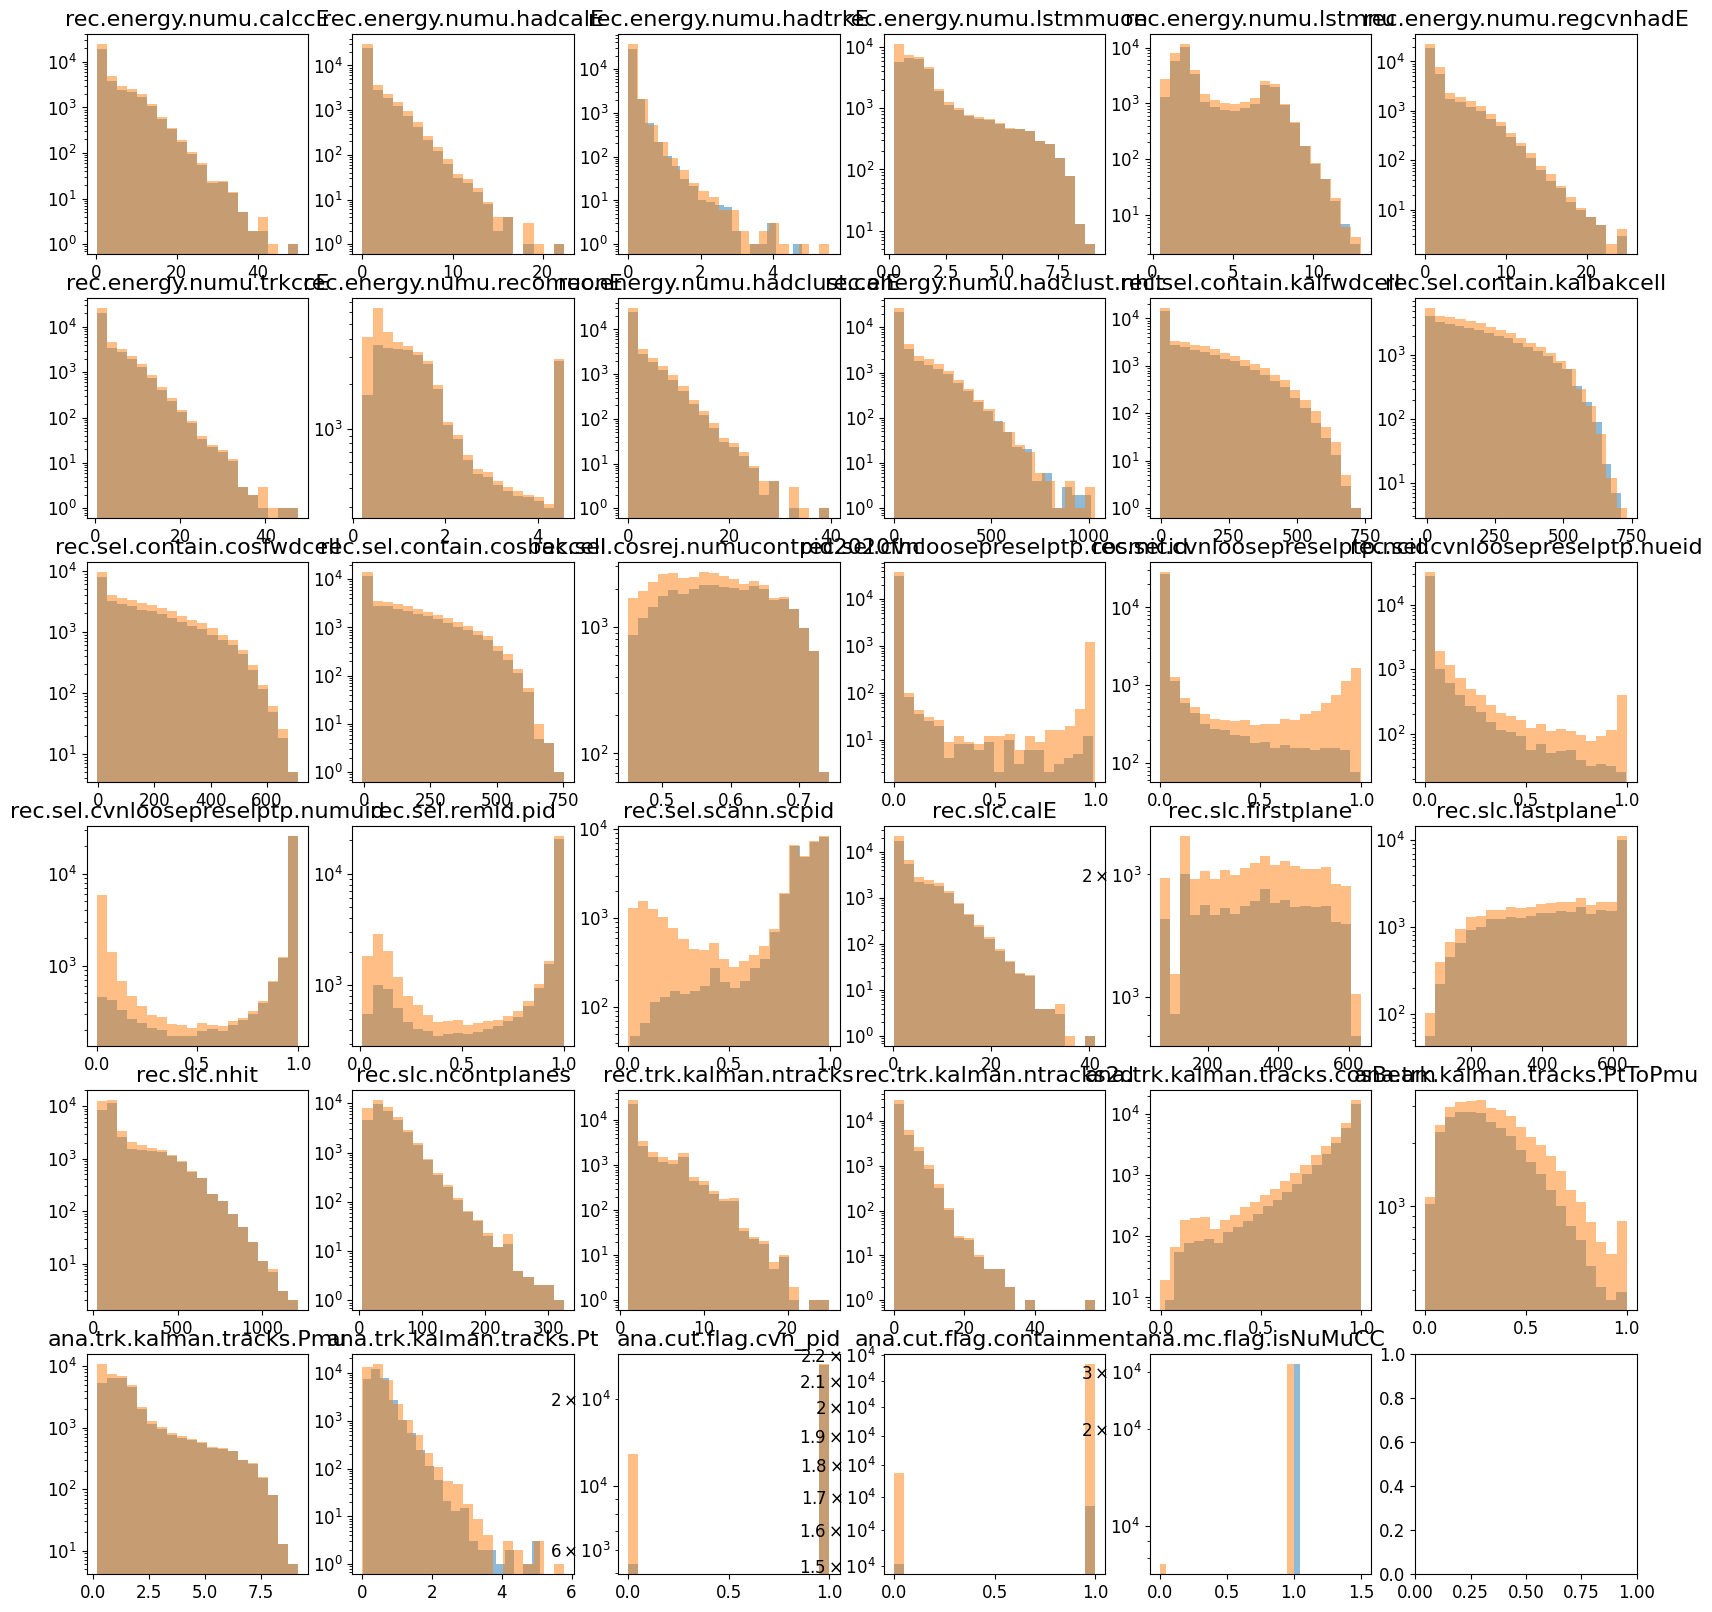

In [ ]:
fig, axs = plt.subplots(6, 6, figsize=(20, 20))

axs = axs.flatten()

for i, ax in enumerate(axs):
    var = useful_vars[i]
    s_vals, edg, *_ = ax.hist(
        table[table['ana.mc.flag.isNuMuCC'] == 1][var],
        bins=20,
        alpha=0.5,
        label='numucc'
    )
    b_vals, edg, *_ = ax.hist(
        table[table['ana.mc.flag.isANuMuCC'] == 0][var],
        bins=20,
        alpha=0.5,
        label='anumucc'
    )
    ax.set_yscale('log')
    ax.set_title(var)

plt.tight_layout();

In [22]:
event_type = (
    table['ana.mc.flag.isNuMuCC'] 
    + 2 * table['ana.mc.flag.isANuMuCC'] 
    + 3 * table['ana.mc.flag.isNuECC'] 
    + 4 * table['ana.mc.flag.isNC']
)
event_type.value_counts()

1.0    31752
4.0     5636
0.0     1417
2.0     1355
3.0      574
Name: count, dtype: int64

In [23]:
table['EventType'] = event_type

In [24]:
useful_vars = [
	# 'rec.energy.numu.lstmmuon',
	# 'rec.energy.numu.recomuonE',
	# 'rec.sel.cosrej.numucontpid2020fhc',
	'rec.sel.cvnloosepreselptp.cosmicid',
	'rec.sel.cvnloosepreselptp.ncid',
	# 'rec.sel.cvnloosepreselptp.nueid',
	'rec.sel.cvnloosepreselptp.numuid',
	'rec.sel.remid.pid',
	'rec.sel.scann.scpid',
    # 'ana.cut.flag.cvn_pid',
    # 'ana.cut.flag.containment',
	# 'ana.mc.flag.isNuMuCC',
    'EventType'
]

scale_vars = [
	'rec.energy.numu.lstmmuon',
	'rec.energy.numu.recomuonE'
]

In [25]:
len(useful_vars)

6

IndexError: list index out of range

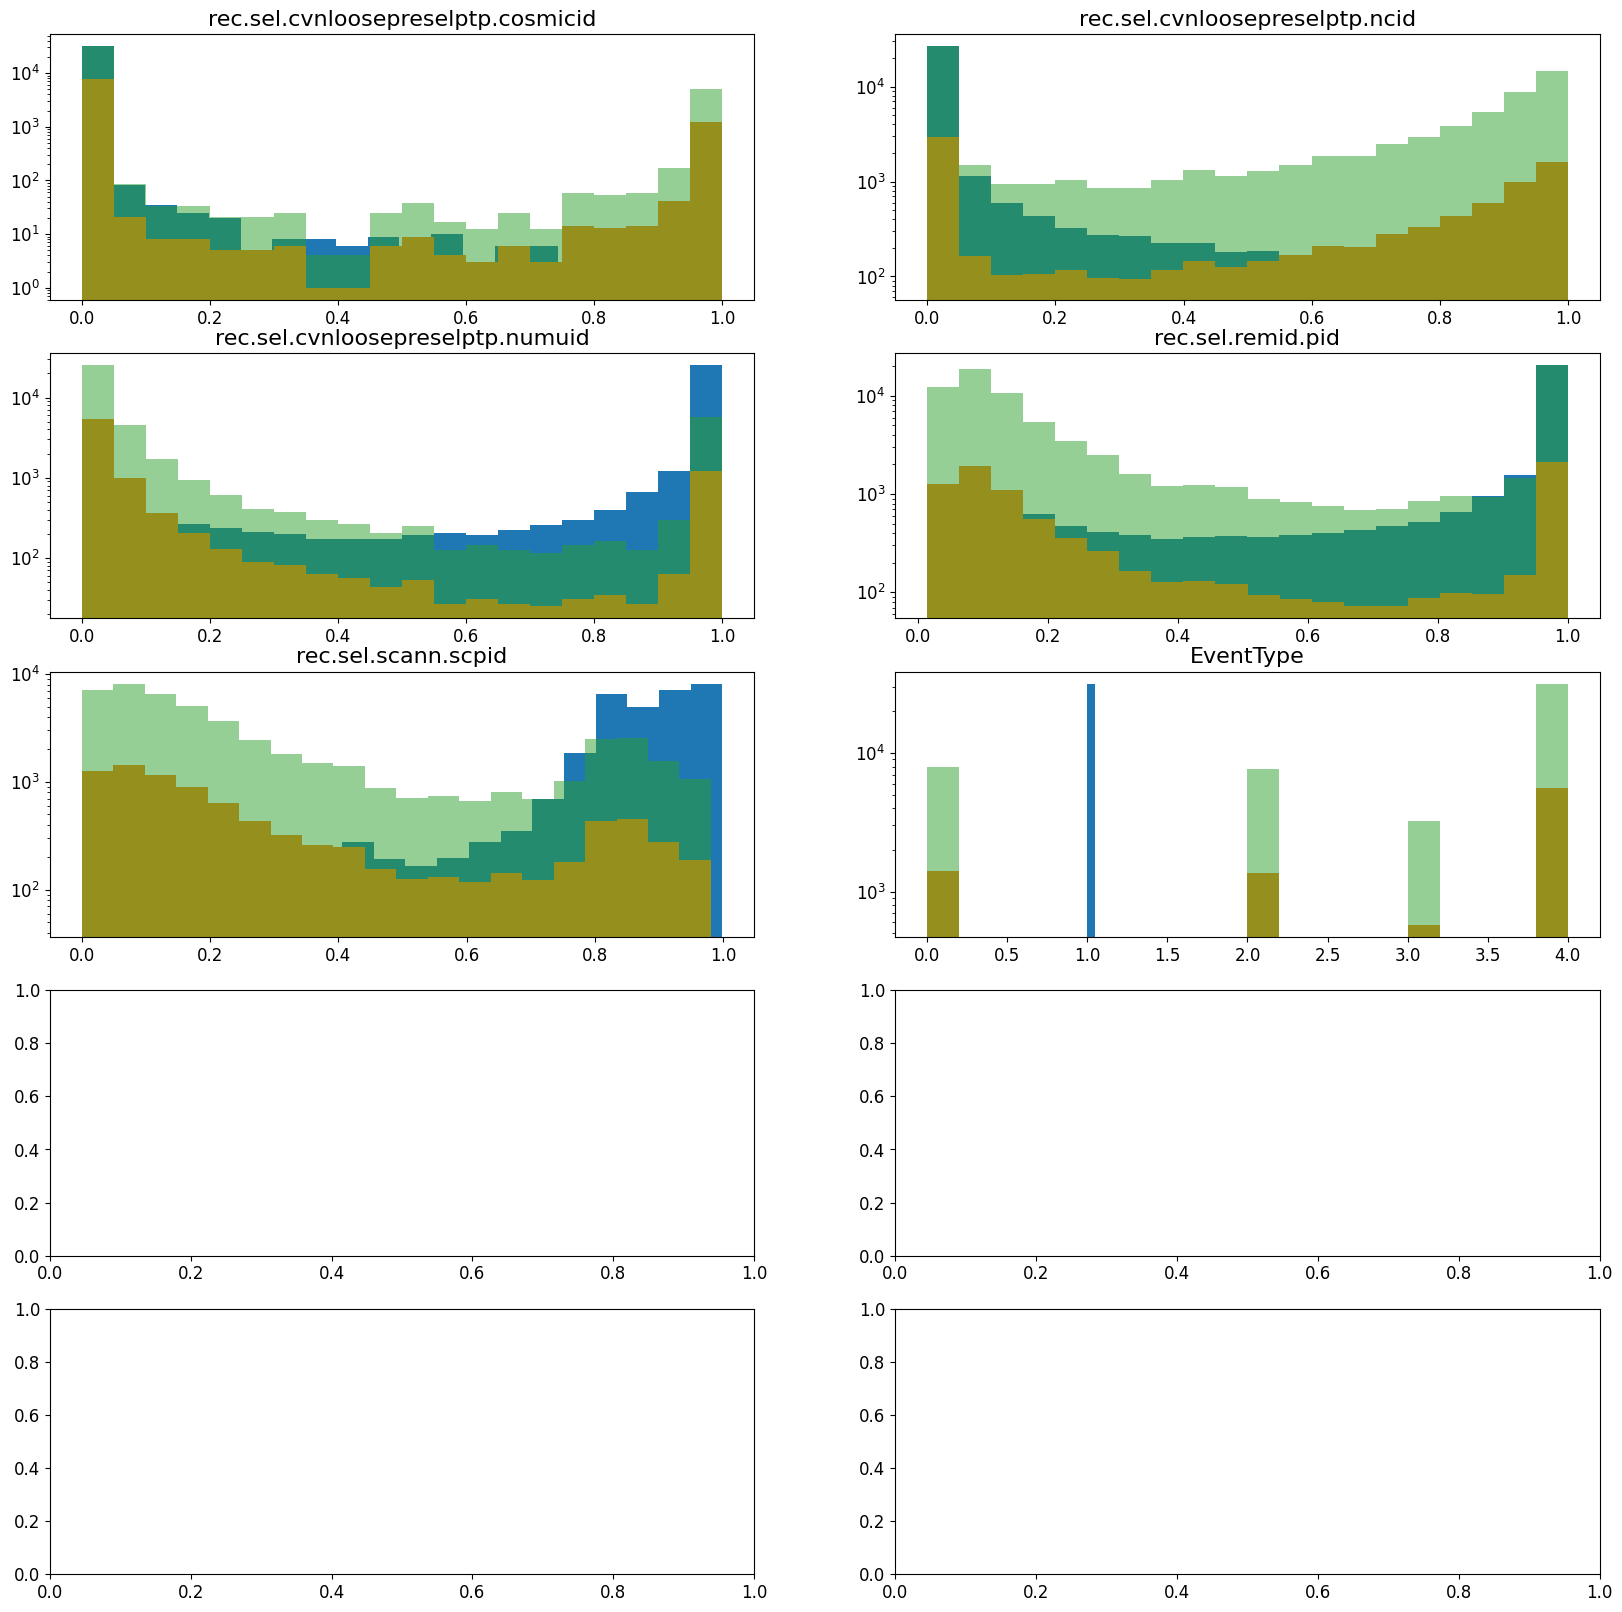

In [26]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))

axs = axs.flatten()

for i, ax in enumerate(axs):
    var = useful_vars[i]

    s_vals, edg, *_ = ax.hist(
        table[table['ana.mc.flag.isNuMuCC'] == 1][var],
        bins=20,
        label='signal'
    )
    b_vals, edg, *_ = ax.hist(
        table[table['ana.mc.flag.isNuMuCC'] == 0][var],
        bins=20,
        label='background'
    )
    ax.hist(
        edg[:-1],
        bins=edg,
        weights=b_vals * (s_vals.max() / b_vals.max()),
        alpha=0.5,
        label='scaled background'
    )
    ax.set_yscale('log')
    ax.set_title(var)

plt.tight_layout();

In [27]:
x_table = table[useful_vars]
# y_table = x_table.pop('ana.mc.flag.isNuMuCC')
y_table = x_table.pop('EventType')

In [29]:
ss = StandardScaler()
# x_table.loc[:, scale_vars] = ss.fit_transform(x_table[scale_vars])

## Random Forest

In [31]:
from sklearn.model_selection import train_test_split
train_table, test_table = train_test_split(
    table, 
    test_size=0.3, 
    random_state=42
)
x_train_table = train_table[useful_vars].reset_index(level=0, drop=True)
y_train_table = x_train_table.pop('EventType')

x_test_table = test_table[useful_vars].reset_index(level=0, drop=True)
y_test_table = x_test_table.pop('EventType')

In [79]:
rf = RandomForestClassifier()
rf.fit(x_train_table, y_train_table)

RandomForestClassifier()

In [80]:
prediction = rf.predict(x_test_table)

In [81]:
y_test_table

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
12216    1.0
12217    1.0
12218    1.0
12219    1.0
12220    1.0
Name: EventType, Length: 12221, dtype: float64

In [82]:
prediction

array([1., 1., 1., ..., 1., 1., 1.])

In [83]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [84]:
y_test_table.value_counts()

EventType
1.0    9530
4.0    1678
0.0     428
2.0     424
3.0     161
Name: count, dtype: int64

In [85]:
9530 + 424

9954

In [86]:
(9530 + 424) / len(y_test_table)

0.81449963178136

In [87]:
pd.Series(prediction).value_counts()

1.0    9935
4.0    1739
0.0     411
3.0     135
2.0       1
Name: count, dtype: int64

In [89]:
(9935 + 1) / len(prediction)

0.8130267572211767

In [71]:
accuracy_score(
    y_pred=(prediction == 1) * 1. + (prediction == 2) * 1., 
    y_true=(y_test_table == 1) * 1. + (y_test_table == 2) * 1.
)

0.9486948694869487

In [72]:
precision_score(
    y_pred=(prediction == 1) * 1. + (prediction == 2) * 1., 
    y_true=(y_test_table == 1) * 1. + (y_test_table == 2) * 1.
)

0.9704428528195299

In [73]:
recall_score(
    y_pred=(prediction == 1) * 1. + (prediction == 2) * 1., 
    y_true=(y_test_table == 1) * 1. + (y_test_table == 2) * 1.
)

0.9664456499899537

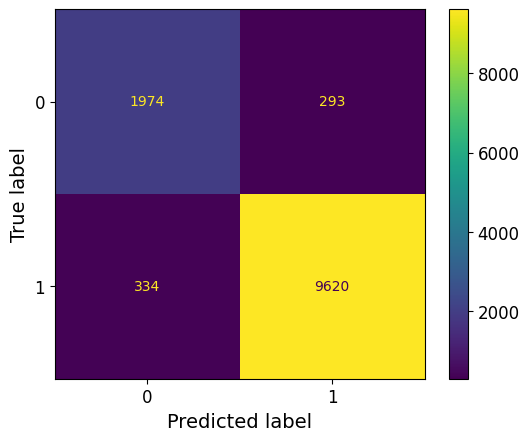

In [74]:
cm = confusion_matrix(
    y_true=(y_test_table == 1) * 1. + (y_test_table == 2) * 1., 
    y_pred=(prediction == 1) * 1. + (prediction == 2) * 1.
)

# TP, FP
# FN, TN

ConfusionMatrixDisplay(cm).plot();

In [75]:
((y_test_table == 1) * 1. + (y_test_table == 2) * 1. == (prediction == 1) * 1. + (prediction == 2) * 1.).value_counts()

EventType
True     11594
False      627
Name: count, dtype: int64

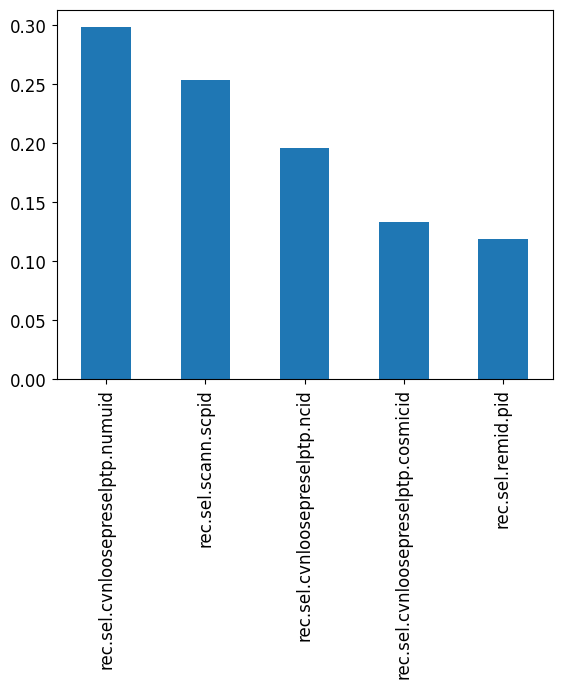

In [76]:
feature_importances = pd.Series(rf.feature_importances_, index=x_train_table.columns).sort_values(ascending=False)
feature_importances.plot.bar();